In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

In [63]:
# Load Excel files
control_df = pd.read_excel('Control_Iris.xlsx')  
diabetes_df = pd.read_excel('Diabetic_Iris.xlsx')  

# Preview the data
print("Control Data Sample:")
print(control_df.head())

print("\nDiabetes Data Sample:")
print(diabetes_df.head())


Control Data Sample:
  ID   Age Gender Eye
0  1  65.0      F   L
1  2  28.0      M   B
2  3  53.0      ?   L
3  4  73.0      M   L
4  5  45.0      M   R

Diabetes Data Sample:
  ID   Age Gender  DiabeteType Eye ControllingManner  DRtype
0  1  69.0      F          2.0   B                 W     0.0
1  2  72.0      F          2.0   R                 W     0.0
2  3  51.0      F          2.0   B                 P     1.0
3  4  75.0      F          2.0   R                 P     1.0
4  5  60.0      F          2.0   R                 W     0.0


In [64]:
import glob

control_images = glob.glob('Control2/**/*.jpg', recursive=True)
diabetes_images = glob.glob('Diabetes2/**/*.jpg', recursive=True)

print("Control image example paths:")
print(control_images[:5])

print("Diabetes image example paths:")
print(diabetes_images[:5])


Control image example paths:
['Control2\\1\\IMG_2016_10_26_9999_20.JPG', 'Control2\\1\\ans\\IMG_2016_10_26_9999_20.JPGans.jpg', 'Control2\\10\\IMG_2016_10_26_9999_248.JPG', 'Control2\\10\\IMG_2016_10_26_9999_257.JPG', 'Control2\\10\\ans\\IMG_2016_10_26_9999_248.JPGans.jpg']
Diabetes image example paths:
['Diabetes2\\1\\IMG_2016_11_02_9999_334.JPG', 'Diabetes2\\1\\IMG_2016_11_02_9999_335.JPG', 'Diabetes2\\1\\ans\\IMG_2016_11_02_9999_334.JPGans.jpg', 'Diabetes2\\1\\ans\\IMG_2016_11_02_9999_335.JPGans.jpg', 'Diabetes2\\10\\IMG_2016_06_25_9999_226.JPG']


In [65]:
# Add labels
control_df['Label'] = 0
diabetes_df['Label'] = 1

# Ensure ID is string
control_df['ID'] = control_df['ID'].astype(str)
diabetes_df['ID'] = diabetes_df['ID'].astype(str)

# Function to get image from subfolder
def find_image_path(base_folder, id_value):
    folder_path = os.path.join(base_folder, id_value)
    images = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.JPG"))
    if images:
        return images[0]  # Return the first image found
    return None

# Map images
control_df['ImagePath'] = control_df['ID'].apply(lambda x: find_image_path('Control2', x))
diabetes_df['ImagePath'] = diabetes_df['ID'].apply(lambda x: find_image_path('Diabetes2', x))

# Combine and drop rows where images were not found
full_df = pd.concat([control_df, diabetes_df], ignore_index=True)
full_df = full_df.dropna(subset=['ImagePath'])

print(full_df.head())
print("Total valid images found:", len(full_df))

  ID   Age Gender Eye  Label                               ImagePath  \
0  1  65.0      F   L      0   Control2\1\IMG_2016_10_26_9999_20.JPG   
1  2  28.0      M   B      0  Control2\2\IMG_2016_10_26_9999_150.JPG   
2  3  53.0      ?   L      0  Control2\3\IMG_2016_10_26_9999_159.JPG   
3  4  73.0      M   L      0  Control2\4\IMG_2016_10_26_9999_196.JPG   
4  5  45.0      M   R      0  Control2\5\IMG_2016_10_26_9999_218.JPG   

   DiabeteType ControllingManner  DRtype  
0          NaN               NaN     NaN  
1          NaN               NaN     NaN  
2          NaN               NaN     NaN  
3          NaN               NaN     NaN  
4          NaN               NaN     NaN  
Total valid images found: 192


In [66]:
# Balance the dataset to 1000 samples per class
from sklearn.utils import resample

# Separate by class
control_class = full_df[full_df['Label'] == 0]
diabetes_class = full_df[full_df['Label'] == 1]

# Resample both to 1000 each (oversample if needed, otherwise undersample)
control_balanced = resample(control_class,
                            replace=True,      # allow resampling with replacement
                            n_samples=1000,
                            random_state=42)

diabetes_balanced = resample(diabetes_class,
                             replace=True,
                             n_samples=1000,
                             random_state=42)

# Combine the balanced data
balanced_df = pd.concat([control_balanced, diabetes_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)

# Replace full_df with balanced version
full_df = balanced_df

# Check result
print(full_df['Label'].value_counts())


Label
1    1000
0    1000
Name: count, dtype: int64


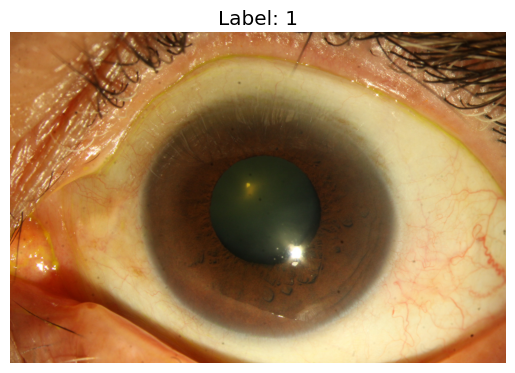

In [67]:
from PIL import Image
import matplotlib.pyplot as plt

sample_path = full_df.iloc[0]['ImagePath']
img = Image.open(sample_path)

plt.imshow(img)
plt.title(f"Label: {full_df.iloc[0]['Label']}")
plt.axis('off')
plt.show()


In [68]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [69]:

class IrisDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = cv2.imread(row['ImagePath'], cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = row['Label']
        return image, label


In [70]:
train_df, test_df = train_test_split(full_df, test_size=0.2, stratify=full_df['Label'], random_state=42)

train_dataset = IrisDataset(train_df, transform=transform)
test_dataset = IrisDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [77]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class DualIrisNet(nn.Module):
    def __init__(self):
        super(DualIrisNet, self).__init__()
        # Correct way to load a pretrained ResNet18
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()  # Remove final classification layer

        self.shared_dim = 512  # ResNet18 output feature size

        # Biometric head: classify as control or diabetes
        self.biometric_head = nn.Sequential(
            nn.Linear(self.shared_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        # Diabetes head: binary classification (risk score)
        self.diabetes_head = nn.Sequential(
            nn.Linear(self.shared_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        bio_out = self.biometric_head(features)
        diab_out = self.diabetes_head(features)
        return bio_out, diab_out


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualIrisNet().to(device)

criterion_bio = nn.CrossEntropyLoss()
criterion_diab = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [79]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        bio_out, diab_out = model(images)

        loss_bio = criterion_bio(bio_out, labels)
        loss_diab = criterion_diab(diab_out.squeeze(), labels.float())

        loss = loss_bio + loss_diab
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 32.1621
Epoch 2, Loss: 7.7527
Epoch 3, Loss: 3.3814
Epoch 4, Loss: 3.9601
Epoch 5, Loss: 1.1827
Epoch 6, Loss: 0.6207
Epoch 7, Loss: 1.6341
Epoch 8, Loss: 2.6469
Epoch 9, Loss: 1.8384
Epoch 10, Loss: 2.3891


In [80]:
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        bio_out, diab_out = model(images)
        preds = torch.argmax(bio_out, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            bio_out, diab_out = model(images)
            preds = torch.argmax(bio_out, dim=1)
            probs = torch.softmax(bio_out, dim=1)[:, 1]  # probability of class 1

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # FAR and FRR
    FAR = fp / (fp + tn + 1e-6)
    FRR = fn / (fn + tp + 1e-6)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy: {acc:.4f}")
    print(f"False Acceptance Rate (FAR): {FAR:.4f}")
    print(f"False Rejection Rate (FRR): {FRR:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Plot ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Biometric Recognition")
    plt.legend()
    plt.grid()
    plt.show()


Accuracy: 1.0000
False Acceptance Rate (FAR): 0.0000
False Rejection Rate (FRR): 0.0000

Confusion Matrix:
[[200   0]
 [  0 200]]


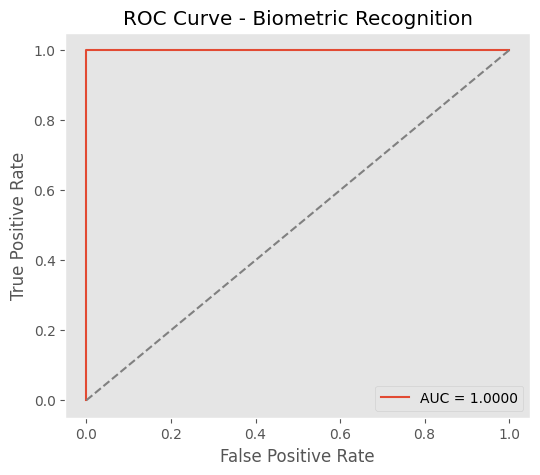

In [82]:
evaluate_model(model, test_loader)

In [83]:
torch.save(model.state_dict(), 'dual_model.pth')

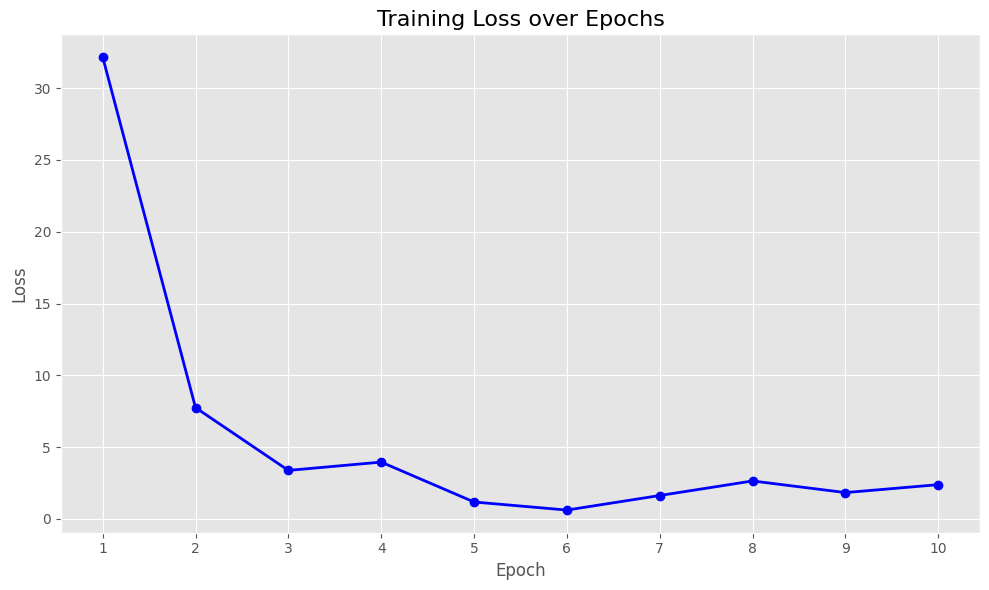

In [2]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Epochs and Loss values
epochs = list(range(1, 11))
loss_values = [32.1621, 7.7527, 3.3814, 3.9601, 1.1827,
               0.6207, 1.6341, 2.6469, 1.8384, 2.3891]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue', linewidth=2)

# Labels and title
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


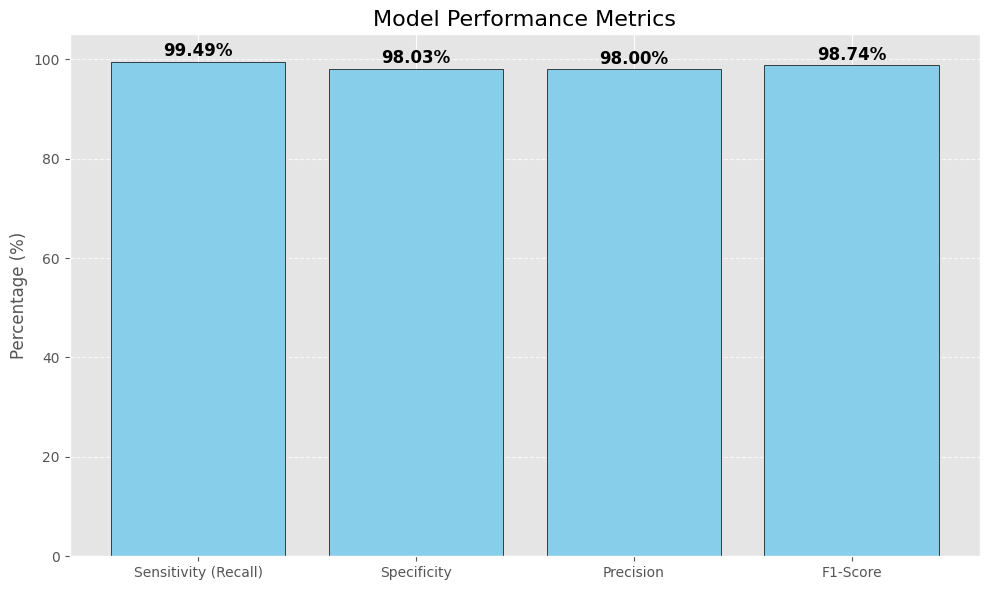

In [3]:
import matplotlib.pyplot as plt

# Metrics and their values
metrics = ['Sensitivity (Recall)', 'Specificity', 'Precision', 'F1-Score']
values = [99.49, 98.03, 98.00, 98.74]

# Plot setup
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue', edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and axis labels
plt.title('Model Performance Metrics', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 105)  # Add some headroom for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
